# [course website](https://dev.mrdbourke.com/tensorflow-deep-learning/09_SkimLit_nlp_milestone_project_2/)

# Libraries

In [1]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.12.0


In [2]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv1D, MaxPool2D, Activation, Embedding, LSTM, GRU, Bidirectional, TextVectorization
from tensorflow.keras import mixed_precision, Sequential, layers
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import itertools
import random
import zipfile
import os
import io
import pathlib
import datetime
import time
import string

In [3]:
!wget https://raw.githubusercontent.com/OFALOFAL/tensorFlow_MyStudySheets/main/TfCommon.py
import TfCommon

--2023-08-11 13:48:45--  https://raw.githubusercontent.com/OFALOFAL/tensorFlow_MyStudySheets/main/TfCommon.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15653 (15K) [text/plain]
Saving to: ‘TfCommon.py’

TfCommon.py         100%[===================>]  15.29K  --.-KB/s    in 0s      

2023-08-11 13:48:45 (107 MB/s) - ‘TfCommon.py’ saved [15653/15653]



# Data

## _1 Downloading and visualising data

In [4]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 15.39 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [5]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [6]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [7]:
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [8]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[10:14]

['RESULTS\tThese differences remained significant at @ weeks .\n',
 'RESULTS\tThe Outcome Measures in Rheumatology Clinical Trials-Osteoarthritis Research Society International responder rate was @ % in the intervention group and @ % in the placebo group ( p < @ ) .\n',
 'CONCLUSIONS\tLow-dose oral prednisolone had both a short-term and a longer sustained effect resulting in less knee pain , better physical function , and attenuation of systemic inflammation in older patients with knee OA ( ClinicalTrials.gov identifier NCT@ ) .\n',
 '\n']

In [9]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    else:
      abstract_lines += line

  return abstract_samples

In [10]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev == val
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 681 ms, sys: 102 ms, total: 783 ms
Wall time: 1.06 s


(180040, 30212, 30135)

In [11]:
train_samples[:3]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11}]

In [12]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(13)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
target_names = np.array(train_df.target.unique())
target_names

array(['OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS', 'BACKGROUND'],
      dtype=object)

In [14]:
train_df.target.value_counts(sort=False)

OBJECTIVE      13839
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
Name: target, dtype: int64

In [15]:
sort = np.argsort(np.array(train_df.target.value_counts(sort=False)))
target_names[sort[-1::-1]]

array(['METHODS', 'RESULTS', 'CONCLUSIONS', 'BACKGROUND', 'OBJECTIVE'],
      dtype=object)

([<matplotlib.axis.XTick at 0x7c30a3c72170>,
 [Text(0.5, 0, 'METHODS'),
  Text(1.5, 0, 'RESULTS'),
  Text(2.5, 0, 'CONCLUSIONS'),
  Text(3.5, 0, 'BACKGROUND'),
  Text(4.5, 0, 'OBJECTIVE')])

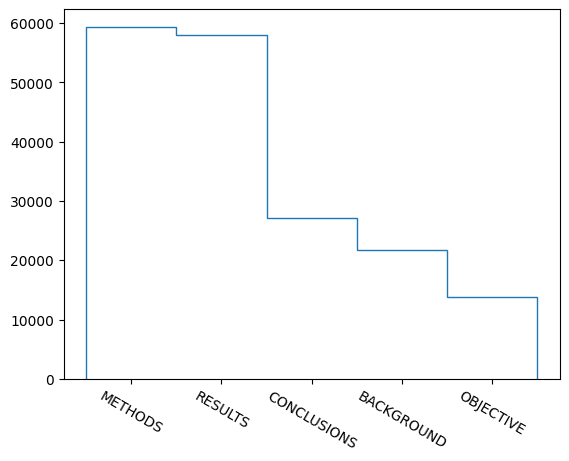

In [16]:
plt.stairs(train_df.target.value_counts())
plt.xticks(np.arange(0.5, len(target_names), 1), target_names[sort[-1::-1]], rotation = -30)

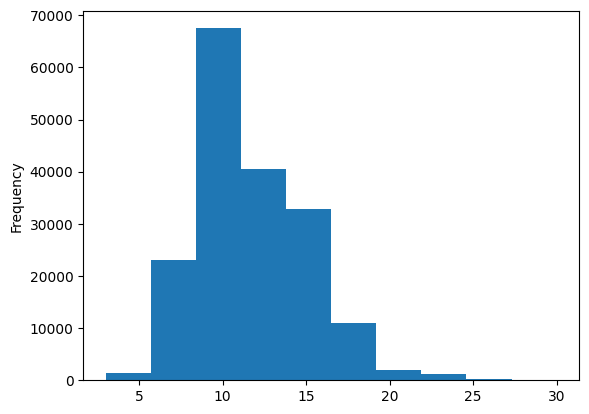

In [17]:
train_df.total_lines.plot.hist();

In [18]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [19]:
train_sentences[:3]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .']

## _2: Pre-Trained Token Embeddings

In [20]:
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [21]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [22]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [23]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([1.1050e+03, 3.5170e+03, 7.7850e+03, 1.3079e+04, 1.6589e+04,
        1.8463e+04, 1.8770e+04, 1.7656e+04, 1.5580e+04, 1.3302e+04,
        1.1002e+04, 9.0040e+03, 7.0390e+03, 5.5540e+03, 4.2780e+03,
        3.3890e+03, 2.7020e+03, 2.1960e+03, 1.7050e+03, 9.5300e+02,
        1.1780e+03, 9.0000e+02, 7.5000e+02, 6.0900e+02, 4.9400e+02,
        4.0100e+02, 3.5000e+02, 2.5000e+02, 2.2900e+02, 2.1500e+02,
        1.6700e+02, 1.2600e+02, 1.0200e+02, 1.0100e+02, 6.4000e+01,
        6.1000e+01, 5.5000e+01, 4.5000e+01, 4.0000e+01, 2.5000e+01,
        2.5000e+01, 2.4000e+01, 2.2000e+01, 1.4000e+01, 1.6000e+01,
        1.0000e+01, 7.0000e+00, 1.6000e+01, 7.0000e+00, 5.0000e+00,
        3.0000e+00, 5.0000e+00, 5.0000e+00, 6.0000e+00, 1.0000e+00,
        3.0000e+00, 1.0000e+00, 4.0000e+00, 4.0000e+00, 0.0000e+00,
        3.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        3.0000e+00, 0.0000e+00, 2.0000e+00, 4.0000e+00, 1.0000e+00,
        0.0000e+00, 3.0000e+00, 2.0000e+00, 1.00

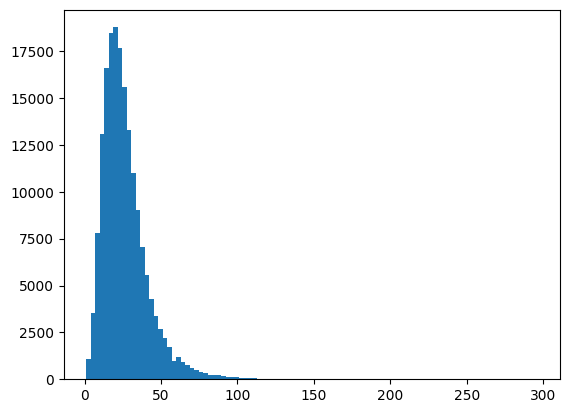

In [24]:
plt.hist(sent_lens, bins=100)

In [25]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [26]:
max_tokens = 68000
text_vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=output_seq_len
)
text_vectorizer.adapt(train_sentences)

In [27]:
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
odds ratios-associated achieving an intermediate @ to @ mmol/l range improved outcome .

Length of text: 13

Vectorized text:
[[  563 47276  1283    26  2122     6   860   283   170    86     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [28]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [29]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [30]:
token_embed = layers.Embedding(
    input_dim=len(rct_20k_text_vocab),
    output_dim=128,
    mask_zero=True,
    name="token_embedding"
)

print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
odds ratios-associated achieving an intermediate @ to @ mmol/l range improved outcome .

Sentence after vectorization (before embedding):
[[  563 47276  1283    26  2122     6   860   283   170    86     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.01881665  0.0329886  -0.0223484  ...  0.01666368 -0.00640859
   -0.00123799]
  [-0.03697381  0.02331335 -0.03874744 ...  0.04016634 -0.04388997
    0.0361484 ]
  [-0.04597298 -0.00372256 -0.02437818 ...  0.01504136 -0.03056239
    0.0400401 ]
  ...
  [-0.01986256 -0.01218246  0.00590045 ... -0.01875187 -0.02538923
    0.01755695]
  [-0.01986256 -0.01218246  0.00590045 ... -0.01875187 -0.02538923
    0.01755695]
  [-0.01986256 -0.01218246  0.00590045 ..

In [31]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [32]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## _3: Character Embeddings

In [33]:
def split_chars(text):
  return " ".join(list(text))

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [34]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([6.7000e+02, 1.3900e+03, 4.0270e+03, 6.2540e+03, 9.7670e+03,
        1.2155e+04, 1.2906e+04, 1.5233e+04, 1.5572e+04, 1.4717e+04,
        1.3744e+04, 1.2475e+04, 1.1130e+04, 8.7230e+03, 7.8800e+03,
        6.6120e+03, 5.3430e+03, 4.2990e+03, 3.5050e+03, 2.6320e+03,
        2.2170e+03, 1.8000e+03, 1.4280e+03, 1.1320e+03, 8.7700e+02,
        6.5700e+02, 4.7400e+02, 4.6100e+02, 3.4000e+02, 3.0300e+02,
        2.4700e+02, 1.9900e+02, 1.4500e+02, 1.1100e+02, 1.0000e+02,
        8.8000e+01, 7.1000e+01, 4.8000e+01, 4.4000e+01, 3.6000e+01,
        2.9000e+01, 2.9000e+01, 1.8000e+01, 2.9000e+01, 1.3000e+01,
        1.3000e+01, 1.4000e+01, 1.0000e+01, 5.0000e+00, 7.0000e+00,
        9.0000e+00, 3.0000e+00, 5.0000e+00, 5.0000e+00, 7.0000e+00,
        2.0000e+00, 3.0000e+00, 4.0000e+00, 2.0000e+00, 2.0000e+00,
        2.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.00

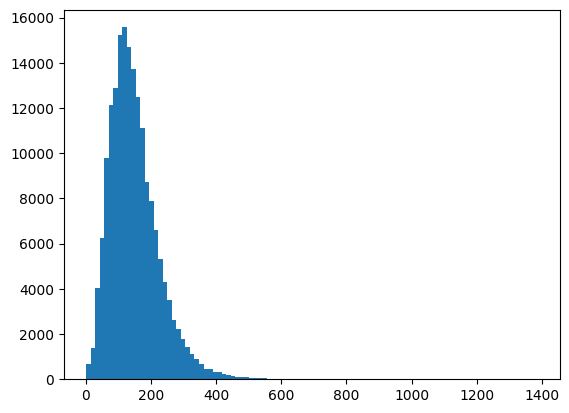

In [35]:
plt.hist(char_lens, bins=100)

In [36]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [37]:
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [38]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

char_vectorizer.adapt(train_chars)

In [39]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [40]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
b a s e l i n e   m e a n   - l s b -   f o r m u l a   :   s e e   t e x t   - r s b -   a w   w a s   i n c r e a s e d   a n d   f e v @   w a s   d e c r e a s e d   w i t h o u t   s i g n i f i c a n t   d i f f e r e n c e s   a m o n g   t h e   @   t r e a t m e n t   d a y s   .

Length of chars: 122

Vectorized chars:
[[22  5  9  2 12  4  6  2 15  2  5  6 12  9 22 17  7  8 15 16 12  5  9  2
   2  3  2 24  3  8  9 22  5 20 20  5  9  4  6 11  8  2  5  9  2 10  5  6
  10 17  2 21 20  5  9 10  2 11  8  2  5  9  2 10 20  4  3 13  7 16  3  9
   4 18  6  4 17  4 11  5  6  3 10  4 17 17  2  8  2  6 11  2  9  5 15  7
   6 18  3 13  2  3  8  2  5  3 15  2  6  3 10  5 19  9  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [41]:
char_embed = layers.Embedding(
    input_dim=NUM_CHAR_TOKENS,
    output_dim=25,
    mask_zero=False,
    name="char_embed"
)

print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
b a s e l i n e   m e a n   - l s b -   f o r m u l a   :   s e e   t e x t   - r s b -   a w   w a s   i n c r e a s e d   a n d   f e v @   w a s   d e c r e a s e d   w i t h o u t   s i g n i f i c a n t   d i f f e r e n c e s   a m o n g   t h e   @   t r e a t m e n t   d a y s   .

Embedded chars (after vectorization and embedding):
[[[ 0.04455543  0.01241275 -0.00169276 ... -0.01191037 -0.01165817
   -0.02011277]
  [-0.02881243  0.00275939 -0.04200137 ...  0.03166511 -0.01468079
   -0.02128565]
  [ 0.01746669 -0.01392559  0.04331524 ...  0.00856693  0.01251299
    0.00192302]
  ...
  [-0.00432925 -0.01919587 -0.01656109 ... -0.00374588 -0.03214727
    0.02943857]
  [-0.00432925 -0.01919587 -0.01656109 ... -0.00374588 -0.03214727
    0.02943857]
  [-0.00432925 -0.01919587 -0.01656109 ... -0.00374588 -0.03214727
    0.02943857]]]

Character embedding shape: (1, 290, 25)


In [42]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## _4: Combined Embeddings

In [43]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [44]:
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## _5: Positional Embeddings dataset

<Axes: ylabel='Frequency'>

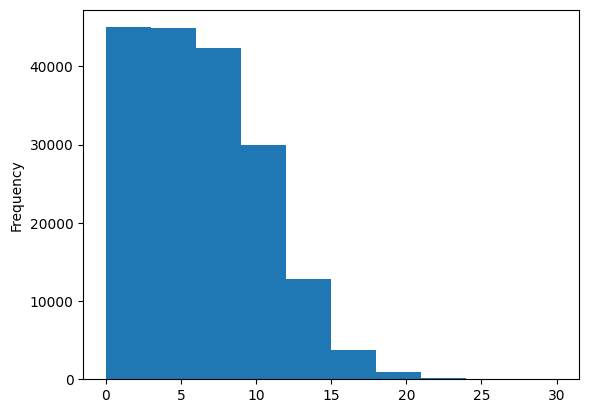

In [45]:
train_df.line_number.plot.hist()

In [46]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:3]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(3, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>)

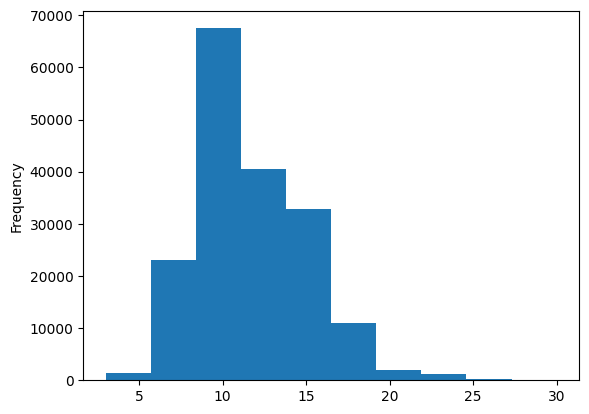

In [47]:
train_df.total_lines.plot.hist();

In [48]:
np.percentile(train_df.total_lines, 98)

20.0

In [49]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:3]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(3, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>)

In [50]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

# Model 0: Baseline

In [51]:
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB()) # model the text
])

model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [52]:
baseline_score = model_0.score(val_sentences, val_labels_encoded)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 72.18%


In [53]:
baseline_preds = model_0.predict(val_sentences)
res_m0 = TfCommon.calculate_results(val_labels_encoded, baseline_preds)
res_m0

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Model 1: Conv1D

In [54]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [55]:
hist_m1 = model_1.fit(
    train_dataset,
    steps_per_epoch=int(0.1 * len(train_dataset)),
    epochs=3,
    validation_data=valid_dataset,
    validation_steps=int(0.1 * len(valid_dataset))
)

Epoch 1/3
562/562 [==============================] - 44s 61ms/step - loss: 0.9233 - accuracy: 0.6316 - val_loss: 0.6861 - val_accuracy: 0.7367
Epoch 2/3
562/562 [==============================] - 9s 15ms/step - loss: 0.6533 - accuracy: 0.7576 - val_loss: 0.6325 - val_accuracy: 0.7676
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.6145 - accuracy: 0.7762 - val_loss: 0.5959 - val_accuracy: 0.7829


In [56]:
ev_m1 = model_1.evaluate(valid_dataset)

model_1_pred_probs = model_1.predict(val_sentences)
print(model_1_pred_probs[:10])

model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
print(model_1_preds[:10])

res_m1 = TfCommon.calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
print(res_m1)
print(np.array(list(res_m1.values())) > np.array(list(res_m0.values())))

945/945 [==============================] - 2s 2ms/step
[[4.17479306e-01 1.59318045e-01 6.45005926e-02 3.35762978e-01
  2.29391120e-02]
 [4.63015527e-01 2.50912905e-01 1.31292176e-02 2.62296170e-01
  1.06462063e-02]
 [1.63323045e-01 4.51707840e-03 1.75246317e-03 8.30334783e-01
  7.26600265e-05]
 [1.39211888e-05 4.34155023e-04 9.86293077e-01 1.35555474e-05
  1.32453805e-02]
 [1.07121922e-03 5.63887507e-02 3.71415526e-01 8.07867909e-04
  5.70316613e-01]
 [2.11013705e-02 3.08697801e-02 5.67264199e-01 1.17218820e-02
  3.69042784e-01]
 [4.40539123e-04 4.25481005e-03 2.52259284e-01 3.36246623e-04
  7.42709100e-01]
 [2.75187101e-02 2.58877520e-02 6.59470022e-01 1.65452696e-02
  2.70578235e-01]
 [2.29722979e-13 2.83743784e-08 1.77919915e-07 8.22785687e-13
  9.99999762e-01]
 [7.34758191e-03 7.22618401e-01 3.34849581e-02 1.29926568e-02
  2.23556474e-01]]
tf.Tensor([0 0 3 2 4 2 4 2 4 1], shape=(10,), dtype=int64)
{'accuracy': 78.66741692042896, 'precision': 0.7834743522758563, 'recall': 0.78667416

# Model_2: Pre-Trained Embeddings

In [57]:
tf_hub_embedding_layer = hub.KerasLayer(
    'https://tfhub.dev/google/universal-sentence-encoder/4',
    trainable=False,
    name='universal_sentence_encoder'
)

In [58]:
random_sentence = random.choice(train_sentences)
print(f"Random_sentence:\n {random_sentence}")
print(f"\nEmbedded random sentence:\n {tf_hub_embedding_layer([random_sentence])[0][:10]}")

Random_sentence:
 we conducted a randomized controlled trial in @ patients with screening-detected hyperglycaemia ( impaired fasting glucose , impaired glucose tolerance or type @ diabetes ) from @ general practices in denmark .

Embedded random sentence:
 [-0.03102475  0.02600428 -0.06529251  0.01689577 -0.05288095  0.01821442
 -0.02159484 -0.04842993  0.05477154 -0.00912734]


In [59]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [60]:
hist_m2 = model_2.fit(
    train_dataset,
    steps_per_epoch=int(0.1 * len(train_dataset)),
    epochs=3,
    validation_data=valid_dataset,
    validation_steps=int(0.1 * len(valid_dataset))
)

Epoch 1/3
562/562 [==============================] - 12s 16ms/step - loss: 0.9182 - accuracy: 0.6482 - val_loss: 0.7968 - val_accuracy: 0.6922
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7685 - accuracy: 0.7023 - val_loss: 0.7532 - val_accuracy: 0.7078
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7503 - accuracy: 0.7125 - val_loss: 0.7360 - val_accuracy: 0.7174


In [61]:
ev_m2 = model_2.evaluate(valid_dataset)

model_2_pred_probs = model_2.predict(val_sentences)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)

res_m2 = TfCommon.calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_2_preds
)

945/945 [==============================] - 12s 12ms/step


In [94]:
print('Predictions:')
print('-'*15)
print(*[f'\t{i}: {x} ({model_2_preds[i]} - {class_names[i]})\n' for i, x in enumerate(model_2_pred_probs[:3])])

print()
print('Overall results:')
print('-'*15)
print(*[f'\t{key}: {value}\n' for key, value in res_m2.items()])

print()
print('Comperings:')
print('-'*15)

results_df = pd.DataFrame({
      'Baseline': np.array(list(res_m0.values())),
      'Conv1D': np.array(list(res_m1.values())),
      'Pre-Trained Embeddings': np.array(list(res_m2.values()))
})
results_df = results_df.transpose()
results_df.columns=['accuracy', 'precision', 'recall', 'f1']
results_df

Predictions:
---------------
	0: [0.43288198 0.36379597 0.00267556 0.19141565 0.00923085] (0 - BACKGROUND)
 	1: [0.3280202  0.5217488  0.00355907 0.14373007 0.00294196] (1 - CONCLUSIONS)
 	2: [0.22083564 0.12795176 0.01657129 0.59316534 0.04147591] (3 - METHODS)


Overall results:
---------------
	accuracy: 71.59406858202038
 	precision: 0.7163493263611923
 	recall: 0.7159406858202039
 	f1: 0.7128864689872925


Comperings:
---------------


,accuracy,precision,recall,f1
Baseline,72.183238,0.718647,0.721832,0.698925
Conv1D,78.667417,0.783474,0.786674,0.784166
Pre-Trained Embeddings,71.594069,0.716349,0.715941,0.712886


# Model_3: Character Embeddings

In [63]:
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(
    inputs=inputs,
    outputs=outputs,
)

model_3.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [64]:
hist_m3 = model_3.fit(
    train_char_dataset,
    steps_per_epoch=int(0.1 * len(train_char_dataset)),
    epochs=3,
    validation_data=val_char_dataset,
    validation_steps=int(0.1 * len(val_char_dataset))
)

Epoch 1/3
562/562 [==============================] - 6s 8ms/step - loss: 1.2559 - accuracy: 0.4966 - val_loss: 1.0368 - val_accuracy: 0.5881
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 1.0029 - accuracy: 0.5940 - val_loss: 0.9509 - val_accuracy: 0.6237
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9331 - accuracy: 0.6306 - val_loss: 0.8828 - val_accuracy: 0.6556


In [65]:
ev_m3 = model_3.evaluate(val_char_dataset)

model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)

res_m3 = TfCommon.calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_3_preds
)

945/945 [==============================] - 3s 3ms/step


In [95]:
print('Predictions:')
print('-'*15)
print(*[f'\t{i}: {x} ({model_3_preds[i]} - {class_names[i]})\n' for i, x in enumerate(model_3_pred_probs[:3])])

print()
print('Overall results:')
print('-'*15)
print(*[f'\t{key}: {value}\n' for key, value in res_m3.items()])

print()
print('Comperings:')
print('-'*15)

results_df = pd.DataFrame({
      'Baseline': np.array(list(res_m0.values())),
      'Conv1D': np.array(list(res_m1.values())),
      'Pre-Trained Embeddings': np.array(list(res_m2.values())),
      'Character Embeddings': np.array(list(res_m3.values()))
})
results_df = results_df.transpose()
results_df.columns=['accuracy', 'precision', 'recall', 'f1']
results_df

Predictions:
---------------
	0: [0.17925303 0.5502302  0.03940379 0.19562735 0.03548567] (1 - BACKGROUND)
 	1: [0.12645917 0.68105644 0.02169339 0.07597353 0.09481749] (1 - CONCLUSIONS)
 	2: [0.08410779 0.35827434 0.2553325  0.17978121 0.12250417] (1 - METHODS)


Overall results:
---------------
	accuracy: 65.32834635244274
 	precision: 0.6443989421677139
 	recall: 0.6532834635244273
 	f1: 0.6404356635543005


Comperings:
---------------


,accuracy,precision,recall,f1
Baseline,72.183238,0.718647,0.721832,0.698925
Conv1D,78.667417,0.783474,0.786674,0.784166
Pre-Trained Embeddings,71.594069,0.716349,0.715941,0.712886
Character Embeddings,65.328346,0.644399,0.653283,0.640436


# Model_4: Combined Methods

In [67]:
token_embedding_inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(token_embedding_inputs)
token_embedding_outputs = layers.Dense(128, activation="relu")(pretrained_embedding)
token_embedding_model = tf.keras.Model(
    inputs=token_embedding_inputs,
    outputs=token_embedding_outputs
)

char_embedding_inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(char_embedding_inputs)
char_embeddings = char_embed(char_vectors)
char_embedding_outputs = layers.Bidirectional(LSTM(units=25))(char_embeddings)
char_embedding_model = tf.keras.Model(
    inputs=char_embedding_inputs,
    outputs=char_embedding_outputs
)

token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_embedding_model.output,
                                                                  char_embedding_model.output])

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
outputs = layers.Dense(num_classes, activation="softmax")(final_dropout)

model_4 = tf.keras.Model(
    inputs=[token_embedding_model.input, char_embedding_model.input],
    outputs=outputs
)

model_4.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_4.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_5[0][0]']                
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['input_4[0][0]']          

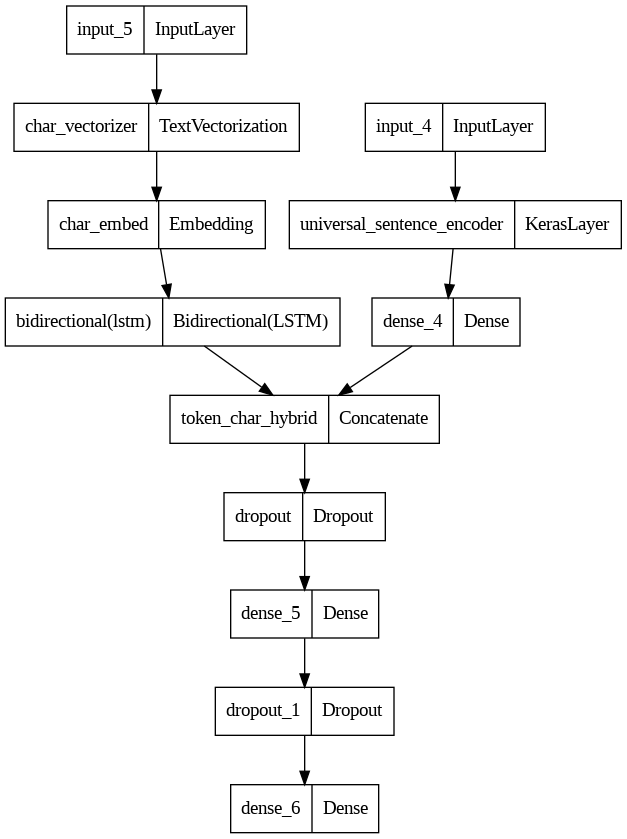

In [68]:
plot_model(model_4)

In [69]:
hist_m4 = model_4.fit(
    train_char_token_dataset,
    steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
    epochs=3,
    validation_data=val_char_token_dataset,
    validation_steps=int(0.1 * len(val_char_token_dataset))
)

Epoch 1/3
562/562 [==============================] - 28s 39ms/step - loss: 0.9697 - accuracy: 0.6114 - val_loss: 0.7906 - val_accuracy: 0.6918
Epoch 2/3
562/562 [==============================] - 20s 35ms/step - loss: 0.7941 - accuracy: 0.6947 - val_loss: 0.7165 - val_accuracy: 0.7327
Epoch 3/3
562/562 [==============================] - 19s 35ms/step - loss: 0.7663 - accuracy: 0.7066 - val_loss: 0.6838 - val_accuracy: 0.7450


In [70]:
ev_m4 = model_4.evaluate(val_char_token_dataset)

model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)

res_m4 = TfCommon.calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_4_preds
)

945/945 [==============================] - 18s 18ms/step


In [96]:
print('Predictions:')
print('-'*15)
print(*[f'\t{i}: {x} ({model_4_preds[i]} - {class_names[i]})\n' for i, x in enumerate(model_4_pred_probs[:3])])

print()
print('Overall results:')
print('-'*15)
print(*[f'\t{key}: {value}\n' for key, value in res_m4.items()])

print()
print('Comperings:')
print('-'*15)

results_df = pd.DataFrame({
      'Baseline': np.array(list(res_m0.values())),
      'Conv1D': np.array(list(res_m1.values())),
      'Pre-Trained Embeddings': np.array(list(res_m2.values())),
      'Character Embeddings': np.array(list(res_m3.values())),
      'Combined Methods': np.array(list(res_m4.values()))
})
results_df = results_df.transpose()
results_df.columns=['accuracy', 'precision', 'recall', 'f1']
results_df

Predictions:
---------------
	0: [0.40649757 0.35434875 0.00488456 0.22641036 0.00785881] (0 - BACKGROUND)
 	1: [0.36416507 0.43329546 0.00250677 0.19875336 0.00127937] (1 - CONCLUSIONS)
 	2: [0.28482825 0.09773312 0.05879275 0.5264269  0.03221897] (3 - METHODS)


Overall results:
---------------
	accuracy: 73.6462332847875
 	precision: 0.7365084581565442
 	recall: 0.736462332847875
 	f1: 0.7339697736046993


Comperings:
---------------


,accuracy,precision,recall,f1
Baseline,72.183238,0.718647,0.721832,0.698925
Conv1D,78.667417,0.783474,0.786674,0.784166
Pre-Trained Embeddings,71.594069,0.716349,0.715941,0.712886
Character Embeddings,65.328346,0.644399,0.653283,0.640436
Combined Methods,73.646233,0.736508,0.736462,0.733970


# Model_5: Positional Embeddings

In [72]:
token_embedding_inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(token_embedding_inputs)
token_embedding_outputs = layers.Dense(128, activation="relu")(pretrained_embedding)
token_embedding_model = tf.keras.Model(
    inputs=token_embedding_inputs,
    outputs=token_embedding_outputs
)

char_embedding_inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(char_embedding_inputs)
char_embeddings = char_embed(char_vectors)
char_embedding_outputs = layers.Bidirectional(LSTM(units=25))(char_embeddings)
char_embedding_model = tf.keras.Model(
    inputs=char_embedding_inputs,
    outputs=char_embedding_outputs
)

token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_embedding_model.output,
                                                                  char_embedding_model.output])

combined_dense = layers.Dense(256, activation="relu")(token_char_concat)
combined_dropout = layers.Dropout(0.5)(combined_dense)

line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32)
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32)
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

final = layers.Concatenate(name="token_char_lines_hybrid")([line_number_model.output,
                                                      total_line_model.output,
                                                      combined_dropout])

outputs = layers.Dense(num_classes, activation="softmax")(final)

model_5 = tf.keras.Model(
    inputs=[
        line_number_model.input,
        total_line_model.input,
        token_embedding_model.input,
        char_embedding_model.input
    ],
    outputs=outputs
)

model_5.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_5.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_7[0][0]']                
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['input_6[0][0]']         

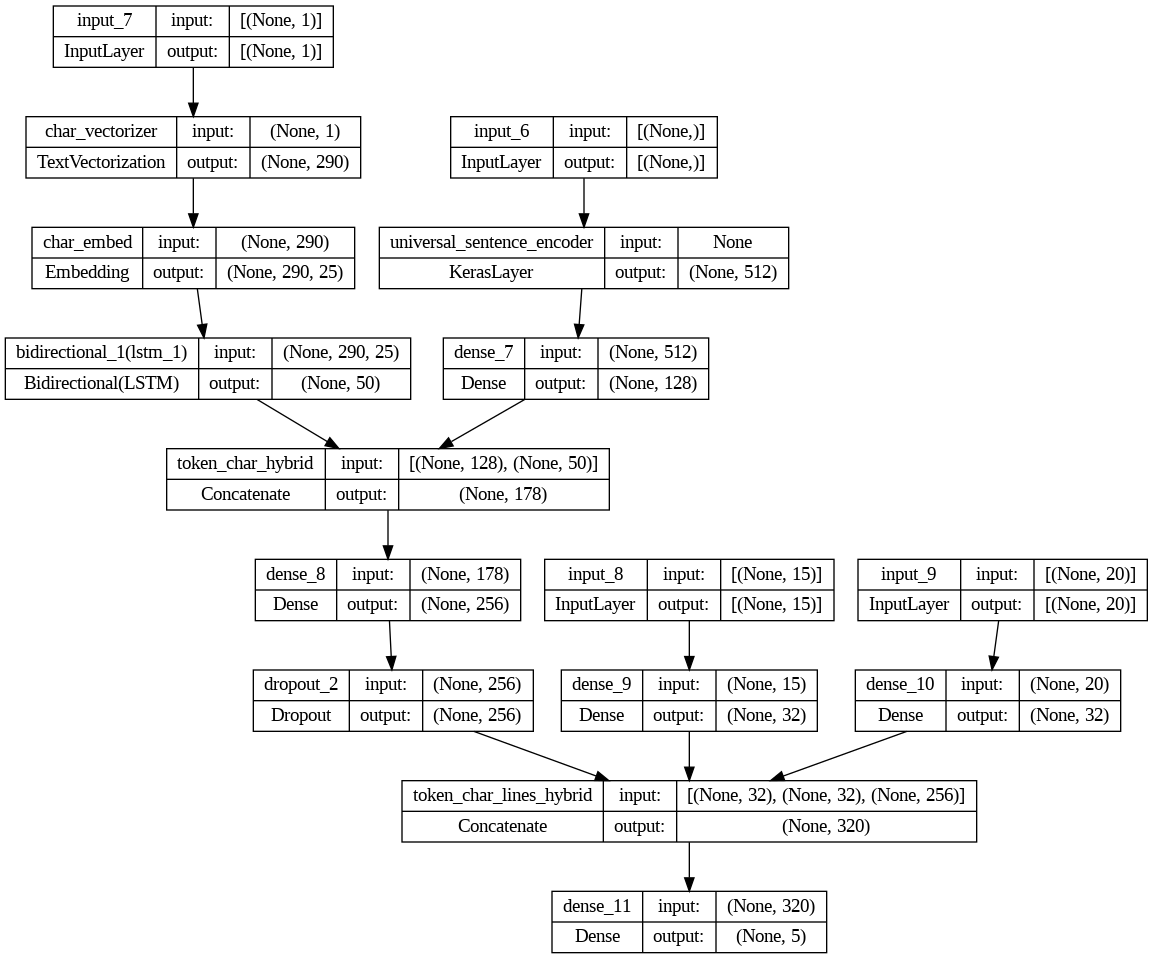

In [77]:
plot_model(model_5, show_shapes=True)

In [74]:
hist_m5 = model_5.fit(
    train_pos_char_token_dataset,
    steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
    epochs=3,
    validation_data=val_pos_char_token_dataset,
    validation_steps=int(0.1 * len(val_pos_char_token_dataset))
)

Epoch 1/3
562/562 [==============================] - 28s 38ms/step - loss: 1.0975 - accuracy: 0.7235 - val_loss: 0.9823 - val_accuracy: 0.8032
Epoch 2/3
562/562 [==============================] - 19s 33ms/step - loss: 0.9686 - accuracy: 0.8157 - val_loss: 0.9496 - val_accuracy: 0.8278
Epoch 3/3
562/562 [==============================] - 23s 41ms/step - loss: 0.9494 - accuracy: 0.8237 - val_loss: 0.9408 - val_accuracy: 0.8281


In [107]:
ev_m5 = model_5.evaluate(val_pos_char_token_dataset)

model_5_pred_probs = model_5.predict(val_pos_char_token_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)

res_m5 = TfCommon.calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_5_preds
)

945/945 [==============================] - 20s 21ms/step


In [103]:
print('Predictions:')
print('-'*15)
print(*[f'\t{i}: {x} ({model_5_preds[i]} - {class_names[i]})\n' for i, x in enumerate(model_5_pred_probs[:3])])

print()
print('Overall results:')
print('-'*15)
print(*[f'\t{key}: {value}\n' for key, value in res_m5.items()])

print()
print('Comperings:')
print('-'*15)

results_df = pd.DataFrame({
      'Baseline': np.array(list(res_m0.values())),
      'Conv1D': np.array(list(res_m1.values())),
      'Pre-Trained Embeddings': np.array(list(res_m2.values())),
      'Character Embeddings': np.array(list(res_m3.values())),
      'Combined Methods': np.array(list(res_m4.values())),
      'Positional Embeddings': np.array(list(res_m5.values()))
    })
results_df = results_df.transpose()
results_df.columns=['accuracy', 'precision', 'recall', 'f1']
results_df

Predictions:
---------------
	0: [0.5022584  0.09879712 0.01195878 0.36810338 0.01888225] (0 - BACKGROUND)
 	1: [0.5016252  0.08814134 0.04578701 0.35221684 0.01222961] (0 - CONCLUSIONS)
 	2: [0.2706684  0.10005748 0.14377816 0.41149017 0.0740059 ] (3 - METHODS)


Overall results:
---------------
	accuracy: 83.11267046206805
 	precision: 0.8302707661319977
 	recall: 0.8311267046206805
 	f1: 0.8302152048090152


Comperings:
---------------


,accuracy,precision,recall,f1
Baseline,72.183238,0.718647,0.721832,0.698925
Conv1D,78.667417,0.783474,0.786674,0.784166
Pre-Trained Embeddings,71.594069,0.716349,0.715941,0.712886
Character Embeddings,65.328346,0.644399,0.653283,0.640436
Combined Methods,73.646233,0.736508,0.736462,0.733970
Positional Embeddings,83.112670,0.830271,0.831127,0.830215


# Comparing results

In [104]:
results_df

,accuracy,precision,recall,f1
Baseline,72.183238,0.718647,0.721832,0.698925
Conv1D,78.667417,0.783474,0.786674,0.784166
Pre-Trained Embeddings,71.594069,0.716349,0.715941,0.712886
Character Embeddings,65.328346,0.644399,0.653283,0.640436
Combined Methods,73.646233,0.736508,0.736462,0.733970
Positional Embeddings,83.112670,0.830271,0.831127,0.830215


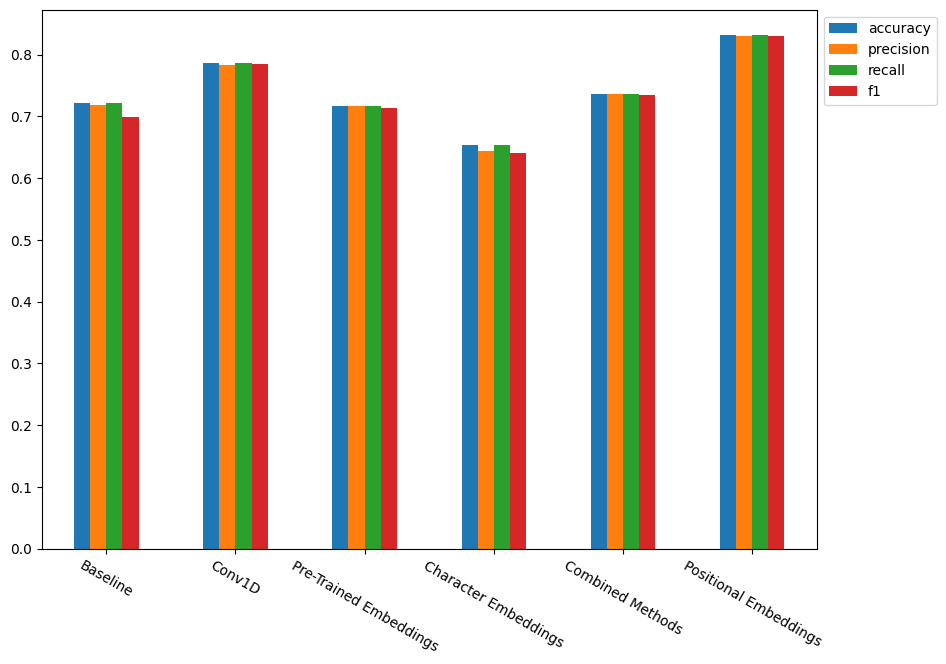

In [105]:
results_df["accuracy"] = results_df["accuracy"]/100
results_df.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation = -30);

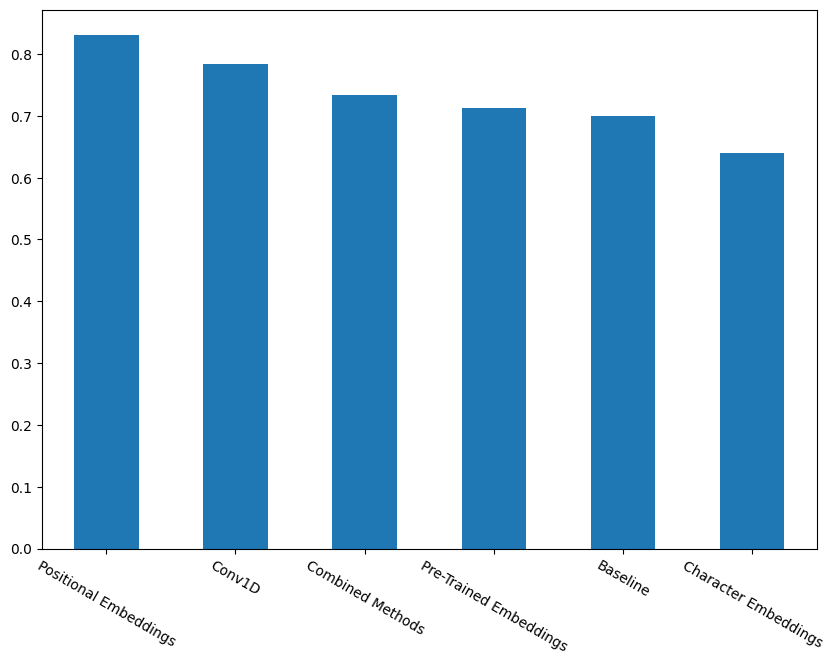

In [106]:
results_df.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));
plt.xticks(rotation = -30);

# Saving and loading models

## Saving

In [113]:
model_1.save('/content/drive/MyDrive/Colab Notebooks/Saved Models/SkimLit_model_1_Conv1D')
model_2.save('/content/drive/MyDrive/Colab Notebooks/Saved Models/SkimLit_model_2_Pre-Trained_Embeddings')
model_3.save('/content/drive/MyDrive/Colab Notebooks/Saved Models/SkimLit_model_3_Character_Embeddings')
model_4.save('/content/drive/MyDrive/Colab Notebooks/Saved Models/SkimLit_model_4_Combined_Methods')
model_5.save('/content/drive/MyDrive/Colab Notebooks/Saved Models/SkimLit_model_5_Positional_Embeddings')

## Loading

In [114]:
# Model_1
model_1 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Saved Models/SkimLit_model_1_Conv1D')
ev_m1 = model_1.evaluate(valid_dataset)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
res_m1 = TfCommon.calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
print(res_m1)

945/945 [==============================] - 3s 3ms/step
{'accuracy': 78.66741692042896, 'precision': 0.7834743522758563, 'recall': 0.7866741692042897, 'f1': 0.7841663111158693}


In [119]:
# Model_2
model_2 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Saved Models/SkimLit_model_2_Pre-Trained_Embeddings')
ev_m2 = model_2.evaluate(valid_dataset)
model_2_pred_probs = model_2.predict(val_sentences)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
res_m2 = TfCommon.calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_2_preds
)
print(res_m2)

945/945 [==============================] - 11s 11ms/step
{'accuracy': 71.59406858202038, 'precision': 0.7163493263611923, 'recall': 0.7159406858202039, 'f1': 0.7128864689872925}


In [118]:
# Model_3
model_3 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Saved Models/SkimLit_model_3_Character_Embeddings')
ev_m3 = model_3.evaluate(val_char_dataset)
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
res_m3 = TfCommon.calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_3_preds
)
print(res_m3)

945/945 [==============================] - 3s 3ms/step
{'accuracy': 61.925724877532105, 'precision': 0.6305571700856643, 'recall': 0.6192572487753211, 'f1': 0.5972271775357904}


In [120]:
# Model_4
model_4 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Saved Models/SkimLit_model_4_Combined_Methods')
ev_m4 = model_4.evaluate(val_char_token_dataset)
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
res_m4 = TfCommon.calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_4_preds
)
print(res_m4)

945/945 [==============================] - 19s 18ms/step
{'accuracy': 73.6958824308222, 'precision': 0.7378204481271021, 'recall': 0.7369588243082219, 'f1': 0.734146464681269}


In [121]:
# Model_5
model_5 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Saved Models/SkimLit_model_5_Positional_Embeddings')
ev_m5 = model_5.evaluate(val_pos_char_token_dataset)
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
res_m5 = TfCommon.calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_5_preds
)
print(res_m5)

945/945 [==============================] - 21s 21ms/step
{'accuracy': 83.11267046206805, 'precision': 0.8302707661319977, 'recall': 0.8311267046206805, 'f1': 0.8302152048090152}
